<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

### ---Import---

In [1]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

2024-07-15 20:40:23.147565: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 20:40:23.173305: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 20:40:23.320902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 20:40:23.320955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 20:40:23.353419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
spam_data = pd.read_csv('spam.csv', encoding='ISO-8859-1', header=0)

In [3]:
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### --- Processing ---

In [4]:
# Basic stats about the dataframe
print(f"Number of rows : {spam_data.shape[0]}")
print()

print("Basic info: ")
spam_data.info()
print()

print("Display of spam_data: ")
display(spam_data.head())
print()

print("Basics statistics: ")
data_desc = spam_data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*spam_data.isnull().sum()/spam_data.shape[0]), columns=['% missing values']))

Number of rows : 5572

Basic info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB

Display of spam_data: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


,% missing values
v1,0.0
v2,0.0
Unnamed: 2,99.0
Unnamed: 3,100.0
Unnamed: 4,100.0


In [5]:
spam_data.loc[spam_data['Unnamed: 2'].notnull(), :]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [6]:
# Combining the columns v2, Unnamed: 2, Unnamed: 3, Unnamed: 4 into one column
spam_data['text'] = spam_data[['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].apply(lambda row: '\n'.join(str(item) for item in row if pd.notnull(item)), axis=1)

In [7]:
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*spam_data.isnull().sum()/spam_data.shape[0]), columns=['% missing values']))

Percentage of missing values: 


,% missing values
v1,0.0
v2,0.0
Unnamed: 2,99.0
Unnamed: 3,100.0
Unnamed: 4,100.0
text,0.0


In [9]:
#Drop the combined columns
spam_data.drop(['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam_data.rename(columns={'v1': 'label'}, inplace=True)

### --- Text cleaning ---

In [10]:
nlp = spacy.load('en_core_web_md')

# Preprocess text
def preprocess_text(text):
    cleaned_text = text
    cleaned_text = ''.join(ch for ch in cleaned_text if ch.isalnum() or ch==" ")
    # Removing double spaces
    cleaned_text = cleaned_text.replace(" +"," ")
    doc = nlp(cleaned_text.strip())  # remove trailing and leading spaces
    lemmatized_text = " ".join([token.lemma_ for token in doc if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)])

    return lemmatized_text.lower()  # return lowercase lemmatized text


In [11]:
spam_data['text_cleaned'] = spam_data['text'].apply(preprocess_text)

In [12]:
spam_data.head()

,label,text,text_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i think usf live


In [13]:
spam_data['label'] = spam_data['label'].replace({'ham': 0, 'spam': 1})

/tmp/ipykernel_248433/4023304015.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_data['label'] = spam_data['label'].replace({'ham': 0, 'spam': 1})


In [14]:
spam_data.head()

,label,text,text_cleaned
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i think usf live


### --- Tokenization ---

In [15]:
max_feature = 10000 #number of unique words to consider
tokenizer = Tokenizer(num_words=max_feature, oov_token='<OOV>')
tokenizer.fit_on_texts(spam_data['text_cleaned'])
spam_data['text_encoded'] = np.array(tokenizer.texts_to_sequences(spam_data['text_cleaned']), dtype=object)

In [16]:
spam_data.head()

,label,text,text_cleaned,text_encoded
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[3710, 234, 449, 464, 950, 36, 53, 205, 951, 8..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[11, 194, 3712, 286, 3, 1485]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 298, 4, 540, 671, 45, 1486, 859, 429, 148..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[3, 127, 151, 2422, 3, 86]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i think usf live,"[716, 2, 24, 672, 132]"


In [17]:
# Train Test Split
X_train, X_val, Y_train, Y_val = train_test_split(spam_data.text_encoded,spam_data.label, test_size=0.25, random_state=42, stratify=spam_data.label)

### --- Padding ---

In [18]:
X_train = pad_sequences(X_train.tolist())
X_val = pad_sequences(X_val.tolist())

In [19]:
X_train.shape, X_val.shape

((4179, 74), (1393, 74))

In [20]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

In [21]:
for t in train.take(1):
    print(t)

(<tf.Tensor: shape=(74,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2024,   84,  377, 1308, 2741,  487,
          2,  105,  377,  468,    6,   84,  113, 7793], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [22]:
#Building batch training and validation datasets
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)

### --- Model architecture ---

In [23]:
vocab_size = tokenizer.num_words
#size of the output vector from each layer
embedding_vector_length = 128
#Creating a sequential model
model = tf.keras.Sequential()
#Creating an embedding layer to vectorize
model.add(Embedding(vocab_size+1, embedding_vector_length, name='embedding', input_length= X_train.shape[1]))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))
#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 128)           1280128   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1381025 (5.27 MB)
Trainable params: 1381025 (5.27 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [25]:
history = model.fit(train_batch, 
                    epochs=30, 
                     validation_data=val_batch)

Epoch 1/30
9/9 [==============================] - 4s 221ms/step - loss: 0.6520 - accuracy: 0.7179 - val_loss: 0.5252 - val_accuracy: 0.8658
Epoch 2/30
9/9 [==============================] - 1s 166ms/step - loss: 0.4186 - accuracy: 0.8660 - val_loss: 0.3531 - val_accuracy: 0.8658
Epoch 3/30
9/9 [==============================] - 1s 166ms/step - loss: 0.3234 - accuracy: 0.8667 - val_loss: 0.2731 - val_accuracy: 0.8658
Epoch 4/30
9/9 [==============================] - 2s 167ms/step - loss: 0.2271 - accuracy: 0.8749 - val_loss: 0.1714 - val_accuracy: 0.9490
Epoch 5/30
9/9 [==============================] - 1s 166ms/step - loss: 0.1333 - accuracy: 0.9761 - val_loss: 0.1192 - val_accuracy: 0.9648
Epoch 6/30
9/9 [==============================] - 1s 164ms/step - loss: 0.0763 - accuracy: 0.9840 - val_loss: 0.0856 - val_accuracy: 0.9756
Epoch 7/30
9/9 [==============================] - 1s 165ms/step - loss: 0.0419 - accuracy: 0.9914 - val_loss: 0.0681 - val_accuracy: 0.9806
Epoch 8/30
9/9 [====

In [26]:
X_val

array([[   0,    0,    0, ...,    0,   56,  684],
       [   0,    0,    0, ..., 6328,  359, 6329],
       [   0,    0,    0, ...,  183,  315,   89],
       ...,
       [   0,    0,    0, ...,    4,   51, 2500],
       [   0,    0,    0, ...,   58,   19,   41],
       [   0,    0,    0, ...,  115, 4980, 4981]], dtype=int32)

In [27]:
Y_predict = [1 if o>0.5 else 0 for o in model.predict(X_val)]

44/44 [==============================] - 1s 6ms/step


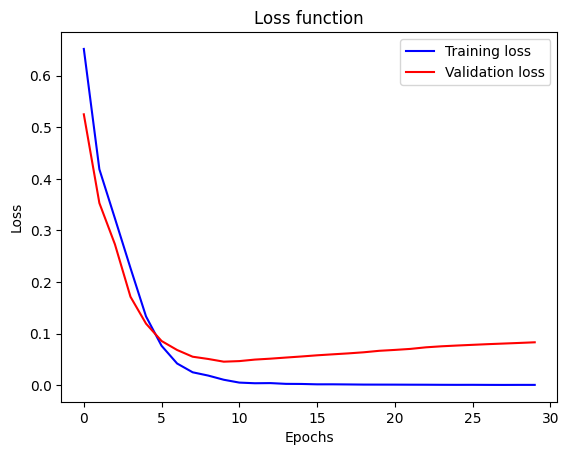

In [28]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label="Training loss")
plt.plot(history.history["val_loss"], color="r", label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss function")
plt.legend()
plt.show()

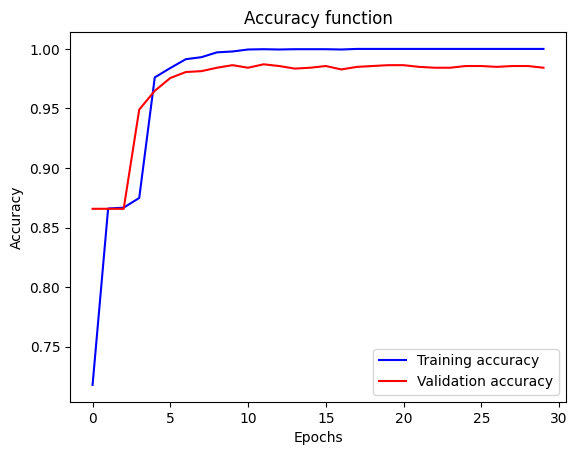

In [29]:
# Visualization of the training process on the metric function 
plt.plot(history.history["accuracy"], color="b", label="Training accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy function")
plt.legend()
plt.show()

In [30]:
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

Precision: 95.08%
Recall: 93.05%
F1 Score: 94.05%


In [31]:
init_weights = model.get_weights()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

model.set_weights(init_weights)

history = model.fit(train_batch,
                    epochs=40,
                    callbacks=[monitor],
                    validation_data=val_batch,
                    verbose=1)

Epoch 1/40
9/9 [==============================] - 2s 172ms/step - loss: 6.1490e-04 - accuracy: 0.9998 - val_loss: 0.0907 - val_accuracy: 0.9806
Epoch 2/40
9/9 [==============================] - 2s 171ms/step - loss: 4.2078e-04 - accuracy: 1.0000 - val_loss: 0.0848 - val_accuracy: 0.9849
Epoch 3/40
9/9 [==============================] - 2s 171ms/step - loss: 3.5840e-04 - accuracy: 1.0000 - val_loss: 0.0837 - val_accuracy: 0.9856
Epoch 4/40
9/9 [==============================] - 2s 169ms/step - loss: 3.1909e-04 - accuracy: 1.0000 - val_loss: 0.0842 - val_accuracy: 0.9864
Epoch 5/40
9/9 [==============================] - 2s 173ms/step - loss: 2.6848e-04 - accuracy: 1.0000 - val_loss: 0.0869 - val_accuracy: 0.9849
Epoch 6/40
9/9 [==============================] - 2s 170ms/step - loss: 2.5387e-04 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9849
Epoch 7/40
9/9 [==============================] - 2s 169ms/step - loss: 3.4539e-04 - accuracy: 1.0000 - val_loss: 0.0892 - val_accuracy:

In [32]:
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

Precision: 95.08%
Recall: 93.05%
F1 Score: 94.05%


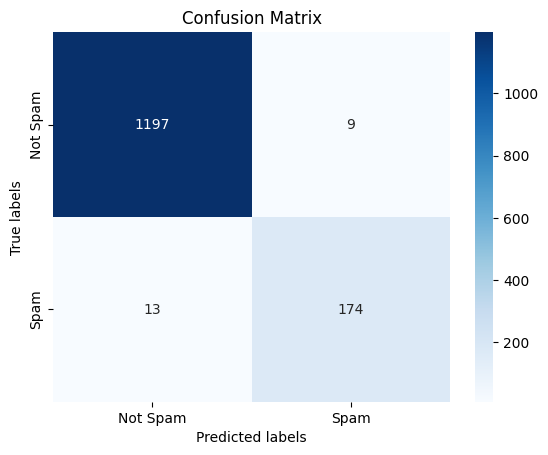

In [33]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

### --- Transfer Learning ---

In [34]:
# Train Test Split
X_train, X_val, Y_train, Y_val = train_test_split(spam_data.text_cleaned,spam_data.label, test_size=0.25, random_state=42, stratify=spam_data.label)

In [35]:
X_train.shape, X_val.shape

((4179,), (1393,))

In [36]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

In [37]:
#Building our batch training and validation datasets
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)

### --- Text embedding model from tf hub ---

In [38]:
base_model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
hub_layer = hub.KerasLayer(base_model, output_shape=[50], input_shape=[], 
                           dtype=tf.string, trainable=True, name="embedding")
embedding = tf.keras.Sequential()
embedding.add(hub_layer)
embedding.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (KerasLayer)      (None, 50)                48190600  
                                                                 
Total params: 48190600 (183.83 MB)
Trainable params: 48190600 (183.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
model = embedding
# Expanding the dimension of the input to fit the embedding layer
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (KerasLayer)      (None, 50)                48190600  
                                                                 
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 256)            183296    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 16)               

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
init_weights = model.get_weights()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (KerasLayer)      (None, 50)                48190600  
                                                                 
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 256)            183296    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 16)               

In [42]:
history = model.fit(train_batch, 
                    epochs=30, 
                     validation_data=val_batch)

Epoch 1/30
9/9 [==============================] - 8s 525ms/step - loss: 0.6831 - accuracy: 0.8031 - val_loss: 0.6628 - val_accuracy: 0.8658
Epoch 2/30
9/9 [==============================] - 4s 407ms/step - loss: 0.6360 - accuracy: 0.8610 - val_loss: 0.5777 - val_accuracy: 0.8658
Epoch 3/30
9/9 [==============================] - 4s 403ms/step - loss: 0.5101 - accuracy: 0.8586 - val_loss: 0.3865 - val_accuracy: 0.8658
Epoch 4/30
9/9 [==============================] - 4s 406ms/step - loss: 0.3399 - accuracy: 0.8598 - val_loss: 0.2809 - val_accuracy: 0.8658
Epoch 5/30
9/9 [==============================] - 4s 402ms/step - loss: 0.2570 - accuracy: 0.8646 - val_loss: 0.2235 - val_accuracy: 0.8715
Epoch 6/30
9/9 [==============================] - 4s 405ms/step - loss: 0.1893 - accuracy: 0.9194 - val_loss: 0.1861 - val_accuracy: 0.9526
Epoch 7/30
9/9 [==============================] - 4s 406ms/step - loss: 0.1492 - accuracy: 0.9737 - val_loss: 0.1593 - val_accuracy: 0.9605
Epoch 8/30
9/9 [====

In [43]:
Y_predict = [1 if o>0.5 else 0 for o in model.predict(X_val)]
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

44/44 [==============================] - 1s 17ms/step
Precision: 89.67%
Recall: 88.24%
F1 Score: 88.95%


In [44]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

model.set_weights(init_weights)

history = model.fit(train_batch,
                    epochs=100,
                    callbacks=[monitor],
                    validation_data=val_batch,
                    verbose=1)

Epoch 1/100
9/9 [==============================] - 4s 432ms/step - loss: 0.6873 - accuracy: 0.7995 - val_loss: 0.6699 - val_accuracy: 0.8658
Epoch 2/100
9/9 [==============================] - 4s 434ms/step - loss: 0.6480 - accuracy: 0.8660 - val_loss: 0.6015 - val_accuracy: 0.8658
Epoch 3/100
9/9 [==============================] - 4s 414ms/step - loss: 0.5399 - accuracy: 0.8653 - val_loss: 0.4087 - val_accuracy: 0.8658
Epoch 4/100
9/9 [==============================] - 4s 410ms/step - loss: 0.3753 - accuracy: 0.8655 - val_loss: 0.2976 - val_accuracy: 0.8658
Epoch 5/100
9/9 [==============================] - 4s 409ms/step - loss: 0.2507 - accuracy: 0.8660 - val_loss: 0.2080 - val_accuracy: 0.8658
Epoch 6/100
9/9 [==============================] - 4s 407ms/step - loss: 0.1811 - accuracy: 0.8732 - val_loss: 0.1700 - val_accuracy: 0.9483
Epoch 7/100
9/9 [==============================] - 4s 407ms/step - loss: 0.1358 - accuracy: 0.9689 - val_loss: 0.1464 - val_accuracy: 0.9720
Epoch 8/100
9

In [45]:
Y_predict = [1 if o>0.5 else 0 for o in model.predict(X_val)]
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

44/44 [==============================] - 1s 15ms/step
Precision: 85.17%
Recall: 95.19%
F1 Score: 89.90%


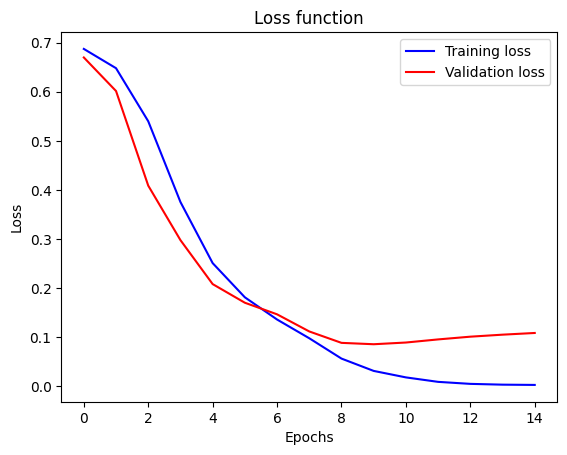

In [46]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label="Training loss")
plt.plot(history.history["val_loss"], color="r", label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss function")
plt.legend()
plt.show()

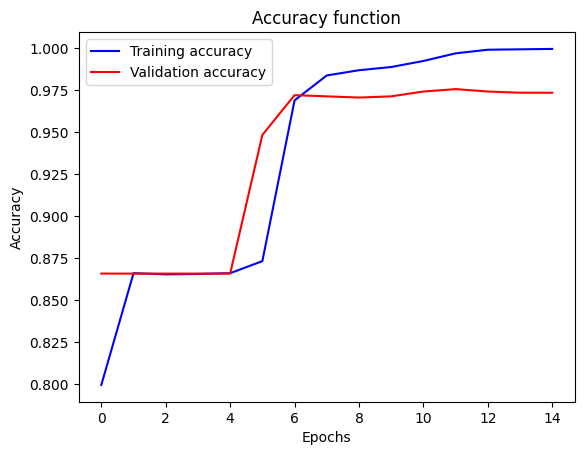

In [47]:
# Visualization of the training process on the metric function 
plt.plot(history.history["accuracy"], color="b", label="Training accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy function")
plt.legend()
plt.show()

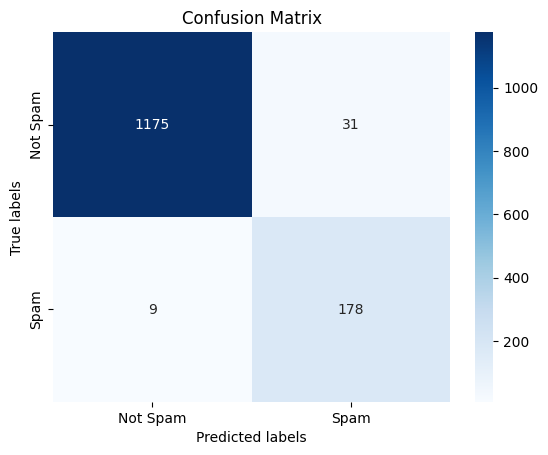

In [48]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);